# Mining Data Streams

Authored and programmed by Linus Östlund and Daniel Workinn.

In this lab, we are supposed to pick a dataset and a paper. Then we're counting triangles.

## Dataset
We use the [Google Webgraph dataset](https://snap.stanford.edu/data/web-Google.html). Potential caveat that it contains *directed* edges. 

| **Property** | **Value** |
| --- | --- |
| Nodes | 875713          |
| Edges | 5105039         |
| Nodes in largest WCC | 855802 (0.977)  |
| Edges in largest WCC | 5066842 (0.993) |
| Nodes in largest SCC | 434818 (0.497)  |
| Edges in largest SCC | 3419124 (0.670) |
| Average clustering coefficient   | 0.5143          |
| Number of triangles              | 13391903        |
| Fraction of closed triangles     | 0.01911         |
| Diameter (longest shortest path) | 21              |
| 90-percentile effective diameter | 8.1             |

## Paper
* ~~We chose the algorithm in the paper [A Space-Efficient Streaming Algorithm for Estimating Transitivity and Triangle Counts Using the Birthday Paradox](https://arxiv.org/pdf/1212.2264.pdf) by M. Jha, C. Seshadhri, and A. Pinar.~~
* Second thought, how about no. Terrible psuedocode made us turn to [TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size](https://www.kdd.org/kdd2016/papers/files/rfp0465-de-stefaniA.pdf)

### How to run this Notebook with Docker
If you want to run this Notebook with Docker, the Jupyter team has several images over at [Docker](https://hub.docker.com/r/jupyter/pyspark-notebook). In the [documentation](https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html) they show an example:

```bash
docker run -p 10000:8888 jupyter/pyspark-notebook:latest
```

Visiting `http://[hostname]:10000/?token=[token]` in a browser loads JupyterLab, where `[hostname] = 0.0.0.0` and `[token]` is generated in the terminal.

I also include a script `start-image.sh` that runs the Docker image with the correct port mapping. Navigate to the directory where the script is located and run:

    
```bash
    bash start-image.sh
```

Then you'll have to copy-paste some stuff from the terminal to your browser or VSC, depending on how you prefer your Jupyter Notebook.

In [1]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("lab3").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
spark

In [2]:
NUMBER_OF_TRIANGLES = 13391903

In [3]:
# read a csv file with pyspark
rdd = spark.read.option("delimiter", "\t").csv("../../data/web-Google.txt", header=True, inferSchema=True)

In [4]:
# show df schema
rdd.show(5)

+----------+--------+
|FromNodeId|ToNodeId|
+----------+--------+
|         0|   11342|
|         0|  824020|
|         0|  867923|
|         0|  891835|
|     11342|       0|
+----------+--------+
only showing top 5 rows



I don't know how to simulate a stream properly, so I'll convert the rdd to a Panda's dataframe, and iterate over each row 🤷🏻‍♂️ Figure out how to do this properly with Kafka is on the todo list.

In [5]:
import pandas as pd
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df = rdd.toPandas()
stream = []
for index, row in df.iterrows():
    edge = (row[0], row[1])
    stream.append(edge)

In order to maintain a subgraph, we implement a `Graph` class which  simulates an undirected graph and holds all edges in an adjacency list. Since we are calling the `neighbors` method a lot, keeping them in an adjency list is more efficient than iterating over the whole list of edges. 

In [6]:
from collections import defaultdict
import random

class Graph:
    """
    A graph object to simplify the implementation of the algorithm
    """
    def __init__(self):
        self.adj_list = defaultdict(set)
        self.edges = 0
    
    def add_edge(self, edge):
        u, v = edge
        self.adj_list[u].add(v)
        self.adj_list[v].add(u)
        self.edges = self.edges + 1
    
    def remove_edge(self, edge):
        u, v = edge
        # remove edge from all neighbors
        self.adj_list[u].remove(v)
        self.adj_list[v].remove(u)
        # the paper says to remove the vertex if it has no neighbors
        self.prune_empty_vertices(edge)
        self.edges = self.edges - 1
    
    def prune_empty_vertices(self, edge):
        u, v = edge
        # adjacency list empty -> remove vertex
        if len(self.adj_list[u]) == 0:
            del self.adj_list[u]
        if len(self.adj_list[v]) == 0:
            del self.adj_list[v]

    def neighbors(self, edge):
        u, v = edge
        # since the edge might come from the stream, we need to check if it is in the graph.
        # If it is not, we return an empty set, else we return the adjecency list of respective vertex
        if u not in self.adj_list or v not in self.adj_list:
            return set()
        else:
            return self.adj_list[u] & self.adj_list[v]
    
    def yield_random_edge(self):
        # pick a random vertex from the graph
        x = random.choice(list(self.adj_list))
        # pick a random neighbor, vertex y, of x
        y = random.choice(list(self.adj_list[x]))
        return (x, y)

Parameters in the paper:

* Our algorithms keep an edge sample $\mathcal{S}$ of up to $M$ edges from the stream (as contrary to sampling with a probability $p$)

* Trièst algorithms keep counters to compute the estimations of the global and local number of triangles. They always keep one global counter $\tau$ for the estimation of the global number of triangles.

* For any t ≥ 0, let $G^S = (V^S, E^S)$ be the subgraph of $G(t)$ containing all and only the edges in the currentsample $\mathcal{S}$. We denote with $\mathcal{N}^S_u$ the neighborhood of $u$ in $G^S: \mathcal{N}^S_u = \{v ∈ V^{(t)}: (u, v) ∈ \mathcal{S}\}$ and with $\mathcal{N}^\mathcal{S}_{u, v} = \mathcal{N}^\mathcal{S}_u \cap \mathcal{N}^\mathcal{S}_v$ the shared neighborhood of $u$ and $v$ in $G^\mathcal{S}$

In [7]:
import numpy as np
from random import sample
from operator import add, sub

class TriestBase:
    # set up nasty globals >_<
    def __init__(self, stream, M=6):
        self.stream = stream
        self.tau = defaultdict(int)
        # TODO borde S vara en adjecency list?
        self.S = Graph()
        self.t = 0
        self.M = M

    def run(self):
        # Here I simulate a stream of edges
        for edge in self.stream:
            self.t+=1
            if self.sample_edge(edge):
                self.S.add_edge(edge)
                self.update_counters(operator=add, edge=edge)

    def sample_edge(self, edge):
        if self.t <= self.M:
            return True
        elif self.flip_biased_coin(self.M/self.t):
            # pick a random edge from S
            random_edge = self.S.yield_random_edge()
            # remove it from S
            self.S.remove_edge(random_edge)
            self.update_counters(operator=sub, edge=random_edge)
            return True
        else:
            return False

    def flip_biased_coin(self, p):
        # TODO is olikheten correct or should it be '>'?
        return np.random.rand() < p

    def update_counters(self, operator, edge):
        u, v = edge
        neighborhood = self.S.neighbors(edge)
        for c in neighborhood:
            # bug here, the operator is malfunctioning???
            self.tau['global'] = operator(self.tau['global'], 1)
            self.tau[c] = operator(self.tau[c], 1)
            self.tau[u] = operator(self.tau[u], 1)
            self.tau[v] = operator(self.tau[v], 1)
    
    def xi(self, t, M):
        f = lambda x: x * (x-1) * (x-2)
        candidate = f(t) / f(M)
        return np.max([1.0, candidate])
    
    def global_estimate(self):
        return self.xi(self.t, self.M) * self.tau['global']


In [8]:
tb = TriestBase(stream, M=40000)
tb.run()

In [9]:
estimate = int(tb.global_estimate())
print(f"estimate: {estimate}")
print(f"actual: {NUMBER_OF_TRIANGLES}")
print(f"error: {int(estimate/NUMBER_OF_TRIANGLES)}%")

estimate: 157561455023
actual: 13391903
error: 11765%


Not even close to the real number, but it works. Probably alot better for smaller networks.


## Triéste Improved

The pseudocode for the improved version of Triéste is found in [the full paper](https://arxiv.org/pdf/1602.07424.pdf), found on Arxiv.

Changes:

* `update_counters` is called for every edge in the stream, not just the ones in the sample
* `update_counters` is modified and using $\eta$ instead of operators $+$ or $-$ for each update.

In [10]:
import numpy as np
from random import sample
from operator import add, sub

class TriestImproved:
    # set up nasty globals >_<
    def __init__(self, stream, M=6, run=False):
        # TODO antagligen krånglar det pga google-grafen är en directed graph
        self.stream = stream
        # defaultdict avoids missing key errors, and with 'int' it defaults to 0
        self.tau = defaultdict(int)
        self.S = Graph()
        self.t = 0
        self.M = M
        if run:
            self.run()

    def run(self):
        # Here I simulate a stream of edges
        for edge in self.stream:
            self.t+=1
            # NOTE modified from BASE
            self.update_counters(edge)
            if self.sample_edge(edge):
                self.S.add_edge(edge)

    def sample_edge(self, edge):
        if self.t <= self.M:
            return True
        elif self.flip_biased_coin(self.M/self.t):
            # pick a random edge from S
            random_edge = self.S.yield_random_edge()
            # remove it from S
            self.S.remove_edge(random_edge)
            return True
        else:
            return False

    def flip_biased_coin(self, p):
        return np.random.rand() < p

    def update_counters(self, edge):
        # NOTE modified from BASE
        u, v = edge
        neighborhood = self.S.neighbors(edge)
        # define f as in the paper
        f = lambda t, M: (t-1) * (t-2) / (M*(M-1))
        # find the maximum of f(t, M) and 1
        eta = np.max([1.0, f(self.t, self.M)])
        for c in neighborhood:
            self.tau['global'] += eta
            self.tau[c] += eta
            self.tau[u] += eta
            self.tau[v] += eta
    
    def global_estimate(self):
        # NOTE modified from BASE, according to 4.2.1 in the full paper
        print(f"t: {self.t}, M: {self.M}, tau: {self.tau['global']}")
        return int(self.tau['global'])

From the paper:

> These results show that trièst-impr is very accurate even when storing **less than a 0.001 fraction of the total edges of the graph**

Let's run one instance with 0.001 of the total edges.

In [11]:
M = int(len(stream)*0.001)
print(f"M: {M}")
tb = TriestImproved(stream, M=M)
tb.run()

M: 5105


In [12]:
estimate = tb.global_estimate()
print(f"Global estimate: {estimate} vs. actual: {NUMBER_OF_TRIANGLES}")
print(f"Error: {int(estimate/NUMBER_OF_TRIANGLES)}%")

t: 5105039, M: 5105, tau: 21580775.4994055
Global estimate: 21580775 vs. actual: 13391903
Error: 1%


Again, not very accurate 🤔 But it's a start.

# Performance

Let's get som statistics on the performance of the algorithm. First we run the algorithm with a sample size of 0.001, and plot the distribution. Since `Triest` is non-deterministic, there's expected variance. Then we alter the $M$ parameter and see if the estimate converge to the true value.

In [13]:

# set M to article's suggested threshold
M = int(len(stream)*0.001)
print(f"M: {M}")
number_of_runs = 10
runs = []
for i in range(number_of_runs):
    ti = TriestImproved(stream, M=M)
    ti.run()
    runs.append(ti.global_estimate())

M: 5105
t: 5105039, M: 5105, tau: 23303631.799356993
t: 5105039, M: 5105, tau: 23554244.068048723
t: 5105039, M: 5105, tau: 27687243.546199176
t: 5105039, M: 5105, tau: 23389054.289440937
t: 5105039, M: 5105, tau: 18670930.37174914
t: 5105039, M: 5105, tau: 27867278.970608067
t: 5105039, M: 5105, tau: 21554721.2383393
t: 5105039, M: 5105, tau: 24040014.795564618
t: 5105039, M: 5105, tau: 24773559.477352943
t: 5105039, M: 5105, tau: 24172020.402545683


 To get a sense of how the runs are distributed, the result is presented as a violin plot, compared to the actual number of triangles in the graph.

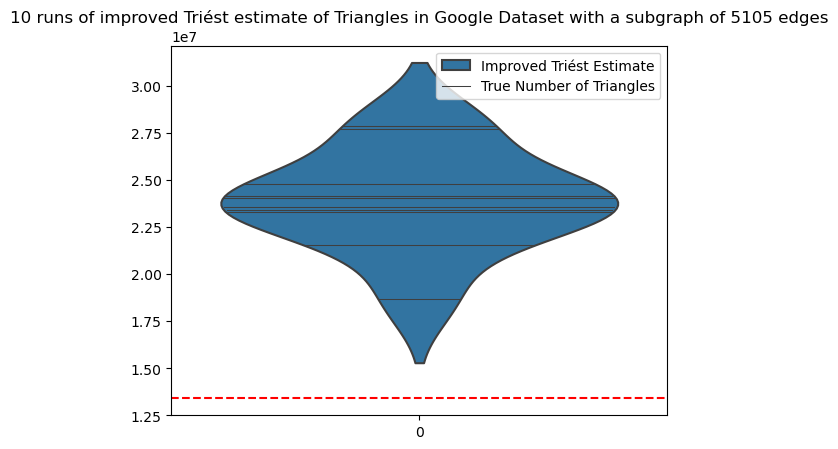

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(runs, inner="stick")
plt.axhline(y=NUMBER_OF_TRIANGLES, color='r', linestyle='--')
plt.legend(title='', loc='upper right', labels=['Improved Triést Estimate', 'True Number of Triangles']);
plt.title('10 runs of improved Triést estimate of Triangles in Google Dataset with a subgraph of 5105 edges');


According to the paper, the algorithm is able to estimate the exact number of triangles when $M \ge t$, and should still be accurate with $0.001\%$ of the stream edges (in this case, $M = 5105$). The improved algorithm seem to have a tendancy to overshoot the number of triangles. So what happens when we increase $M$?

First, let's repeat the above experiment with `TriestBase`.

In [15]:
# göra en metod som kallar på TriestBase snarare än att försöka mata in objektet?
def benchmark_base(stream, M):
    triest = TriestBase(stream, M=M)
    triest.run()
    return triest.global_estimate()

def benchmark_improved(stream, M):
    triest = TriestImproved(stream, M=M)
    triest.run()
    return triest.global_estimate()


In [16]:
from threading import Thread
benchmarks = []
number_of_runs = 10

M = [int(len(stream)*0.001) for i in range(10)]

threads = []

def run_benchmark(benchmarks, stream, m):
  benchmarks.append(benchmark_base(stream, m))

for m in M:
    t = Thread(target=run_benchmark, args=(benchmarks, stream, m))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

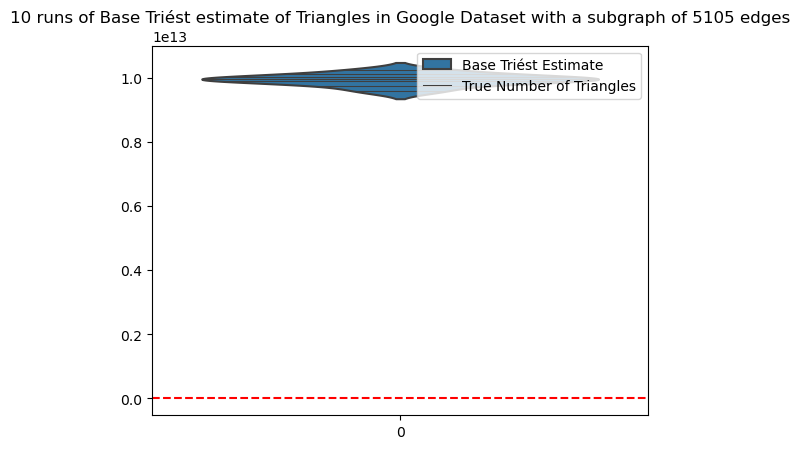

In [20]:
import matplotlib.pyplot as plt

sns.violinplot(benchmarks, inner="stick")
plt.axhline(y=NUMBER_OF_TRIANGLES, color='r', linestyle='--')
plt.legend(title='', loc='upper right', labels=['Base Triést Estimate', 'True Number of Triangles']);
plt.title('10 runs of Base Triést estimate of Triangles in Google Dataset with a subgraph of 5105 edges');


Apperently, the `Base` algorithm is terrible when it comes to estimating the number of triangles with a low sample size. 

# Convergence
Let's plot the estimate of different runs of the algorithm, and see if it converges to the true value. We run the algorithm with different sample sizes, and compare it to the actual number of triangles in the graph.


In [23]:
from threading import Thread
convergence_base = []
convergence_improved = []
number_of_runs = 10

M = [int(len(stream)*0.001*i) for i in range(1, 10)]

threads = []

def run_convergence(convergence, stream, m):
  convergence.append(benchmark_base(stream, m))

for m in M:
    t = Thread(target=run_convergence, args=(convergence_base, stream, m))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

In [24]:
for m in M:
    t = Thread(target=run_convergence, args=(convergence_improved, stream, m))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

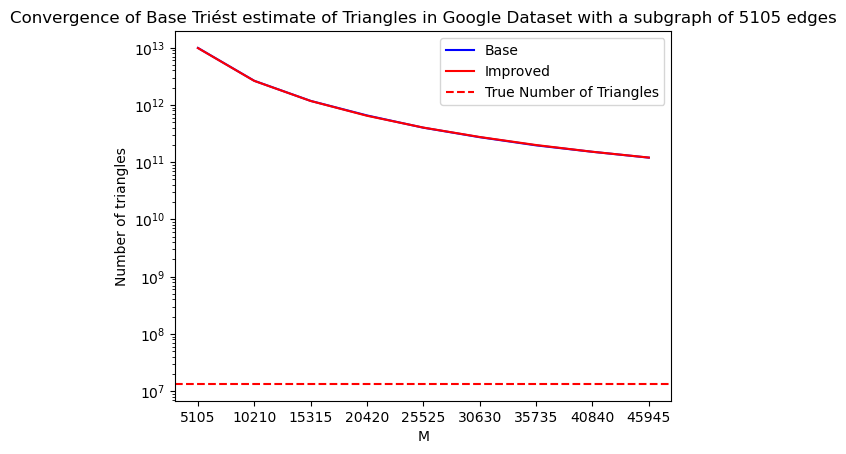

In [29]:
plt.plot(convergence_base, label='Base', color='b')
plt.plot(convergence_improved, label='Improved', color='r')
plt.axhline(y=NUMBER_OF_TRIANGLES, color='r', linestyle='--')
plt.xlabel('M')
plt.ylabel('Number of triangles')
plt.xticks(range(len(M)), M)
plt.yscale('log')
plt.legend(title='', loc='upper right', labels=['Base','Improved', 'True Number of Triangles']);
plt.title('Convergence of Base Triést estimate of Triangles in Google Dataset with a subgraph of 5105 edges');


> **Final note:** Please note this final graph was made very close to the deadline. Due to overly ambitious plans to have 100 runs of varying $M$-values, the cells were having very long run times. We'll work on it before the presentation. Take this plot with a grain of salt, as it probably is inaccurate with respect to the `Base` and `Improved` camparison.

# Bonus questions

## What were the challenges you faced when implemented the algorithm?
Although the pseudocode was clear, once implemented, it was hard to debug the code. Finding a good representetion of the data structures was a challenge. We approached the subgraph $S$ in various ways, and realised the dataset is *directed*, while the paper assumes an undirected graph. We settled on adjency lists. The estimates of the number of triangles were also quite off, and we had to do some digging to find out why. We are still not sure exactly why, but suspect the M-values we've evaulated the algorithm with are far too low. The paper has a lot of benchmarking and evaluations, but they don't use the best kind of visualization to show the results. It would be interesting to see their result as a violin or box plot, to see the distribution of several estimates.

## Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.
We don't think it can be easily parallelized. The algorithm is sampling of edges in a non-deterministic way, and after execution, the sample is used to estimate the number of triangles. If we were to parallelize the algorithm, we would have to make sure that the sample is the same across all threads.  Due to the estimate relying on the sample, this would require some sort of synchronization. If possible, it would be difficult to implement. Some parts of the algoritm might be possible to parallize, but the speedup wouldn't be so good. We'd say this is a one-pass, single-threaded algorithm.

## Does the algorithm work for unbounded graph streams? Explain.
Yes it does, since it relies on a resorvoir (or *edge sample*) of size $M$. In practice, Triéste is used for graphs with millions of edges, and can at any time be queried for the estimate of number of triangles in the graph. The only limitation is that the algorithm needs to be able to store the resorvair in memory.

## Does the algorithm support edge deletions? If not, what modification would it need? Explain.
The third algorithm in the paper is *fully dynamic*, meaning that edges can be added and removed at any time. However, `Base` and `Improved` does not support edge deletions. The fully dynamic algorithm keeps track of edges removed and affected at time $t$, and later compensates for them. Simply put, it requires more bookkeeping. The global triangle estimate is modified and introduces new variables, which rely on mathematics that we believe is beyond the scope of this course.